In [14]:
import numpy as np
from tqdm import tqdm
from mido.midifiles.midifiles import MidiFile
from pathlib import Path

In [15]:
test_file = "data/Bach-ItalienischesKonzert.mid"
midi_file = MidiFile(test_file)

In [16]:
midi_file.ticks_per_beat

480

In [17]:
print(f"The song has {len(midi_file.tracks)} tracks")

The song has 2 tracks


In [18]:
for track in midi_file.tracks:
    print(f"Track {track.name} has {len(track)} messages")

Track Rechts 16 has 2830 messages
Track Links 16 has 2194 messages


## Midi files
Midi files are a type of file that contains music data.
- Midi files contain events that describe the music, such as note-on, note-off. 
- Each event has a timestamp, which is relative to the previous event.

We want to extract the events from the midi files and convert them to a format that can be used for training a neural network.

In [19]:

class NoteEvent:
    def __init__(self, note: int, velocity: int, start: int, hand: str = None):
        self.note = note
        self.velocity = velocity
        self.start = start
        self.end = None
        self.hand = hand

    def set_end(self, end):
        self.end = end

class MidiEventProcessor:
    """
    The purpose of this class is to extract note events from a midi file.
    The extract_note_events method returns a list of NoteEvent objects.
    """
    def __init__(self):
        self.note_events: list[NoteEvent] = []

    def _create_note_event(self, active_notes, midi_message, timestamp, hand: str):
        note_event = NoteEvent(midi_message.note, midi_message.velocity, timestamp, hand)
        active_notes[midi_message.note] = note_event

    def _process_note_off_event(self, note_events, active_notes, midi_message, timestamp):
        note_event = active_notes.get(midi_message.note)
        if note_event and note_event.end is None:
            note_event.set_end(timestamp)
            note_events.append(note_event)
            active_notes[midi_message.note] = None

    def _process_midi_track(self, note_events: list, midi_track, hand: str):
        cumulative_time = 0  
        active_notes = {}
        for _, midi_message in enumerate(midi_track):
            cumulative_time += midi_message.time
            if midi_message.type == "note_on":
                self._create_note_event(active_notes, midi_message, cumulative_time, hand)
            elif midi_message.type == "note_off":
                self._process_note_off_event(note_events, active_notes, midi_message, cumulative_time)

    def _extract_and_process_midi_tracks(self, midi_file_path) -> list[NoteEvent]:
        note_events = []
        midi_file = MidiFile(midi_file_path)
        for i, midi_track in enumerate(midi_file.tracks):
            hand = "right" if i == 1 else "left"
            self._process_midi_track(note_events, midi_track, hand)
        return sorted(note_events, key=lambda x: x.start)

    def extract_note_events(self, midi_file_path: Path) -> list[NoteEvent]:
        return self._extract_and_process_midi_tracks(midi_file_path)

In [20]:
mp = MidiEventProcessor()
# the events are now sorted by the start time
events = mp.extract_note_events(Path(test_file))
events[:3]

In [21]:
def to_json(events, output_file_path: Path):
    import json
    json_events = []
    for event in events:
        json_events.append({
            "note": event.note,
            "velocity": event.velocity,
            "start": event.start,
            "end": event.end,
            "hand": event.hand
        })
    with open(output_file_path, "w") as f:
        json.dump(json_events, f)
to_json(events, Path("events/Bach-ItalienischesKonzert.json"))

## Preprocessing
Here are multiple ways to represent the events in a window:
- unidirectional? Only take the past events into account.
    - This is the simplest approach.
    - Will not be needed for the final model, since it will only be used with pre recorded data.
- bidirectional? Take both the past and future events into account.
    - Using masked pretraining like a BERT style model?
- Using a windowed approach?
    - Be careful when splitting the data into train test splits.
- one label per window or one label per event?
    - Given seuqnece should one value be outputted or multiple values?
    - Output at each time step or only at the end of the sequence?
- should right hand and left hand be used as a feature?

In [22]:
def preprocess_window(window: list[NoteEvent]):
    """ Convert the list of notes to a numpy array, also normalize the start times """
    window = np.array([(n.note, n.velocity, n.start) for n in window], dtype=np.float32)
    window[:, 2] = window[:, 2] / window[-1, 2]
    return window

def extract_windows_and_labels(events, window_size, step_size, bidirectional=False):
    windows = []
    labels = []
    for i in range(0, len(events) - window_size, step_size):
        window = events[i:i + window_size]
        windows.append(preprocess_window(window))
        if bidirectional:
            n: NoteEvent = window[window_size // 2]
            label = 0 if n.hand == "left" else 1
            labels.append(label)
        else:
            n: NoteEvent = window[-1]
            label = 0 if n.hand == "left" else 1
            labels.append(label)
    return windows, labels

In [23]:
windows, labels = extract_windows_and_labels(events, window_size=30, step_size=1, bidirectional=False)

print(f"number of windows: {len(windows)}")
print(f"window shape: {windows[0].shape}")
print(f"window label: {labels[0]}")

number of windows: 2472
window shape: (30, 3)
window label: 0


In [24]:
from torch.utils.data import DataLoader, random_split

paths = list(Path("data").rglob("*.mid"))
print(f"Found {len(paths)} midi files")

# split paths into train and validation
train_paths, val_paths, test_paths = random_split(paths, [0.8, 0.1, 0.1])

Found 122 midi files


In [25]:
# now we want to extract windows from all files
def extract_windows_from_files(paths, window_size, step_size):
    all_windows = []
    all_labels = []
    mp = MidiEventProcessor()
    for path in tqdm(paths):
        events = mp.extract_note_events(path)
        windows, labels = extract_windows_and_labels(events, window_size, step_size)
        all_windows.extend(windows)
        all_labels.extend(labels)
    return np.array(all_windows), np.array(all_labels)

train_windows, train_labels = extract_windows_from_files(train_paths, window_size=30, step_size=1)
val_windows, val_labels = extract_windows_from_files(val_paths, window_size=30, step_size=1)

  0%|          | 0/98 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 22.60it/s]


In [26]:
class MidiDataset:
    def __init__(self, windows, labels):
        self.windows = windows
        self.labels = labels

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        return self.windows[idx], self.labels[idx]

In [27]:
# create a data loader
batch_size = 64
train_dataset = MidiDataset(train_windows, train_labels)
val_dataset = MidiDataset(val_windows, val_labels)
# split dataset in train and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [28]:
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel(input_size=3, hidden_size=16, num_layers=2, num_classes=1).to(device)

example = next(iter(train_loader))
events = example[0].to(device)
print(model(events).shape)
print(example[1].unsqueeze(1).shape)

torch.Size([64, 1])
torch.Size([64, 1])


In [29]:
# hyperparameters
num_epochs = 20
input_size = 3
hidden_size = 16
num_layers = 2
num_classes = 1

In [30]:

# model
model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
accuracies = []
val_accuracies = []
all_acc = []

def accuracy(y_true: list[int], y_pred: list[int]):
    return np.mean(np.array(y_true) == np.array(y_pred))


for epoch in range(num_epochs):
    epoch_losses = []
    y_true = []
    y_pred = []
    for i, (windows, labels) in tqdm(enumerate(train_loader), total=len(train_loader), unit="batch"):
        windows = windows.to(device)
        labels = labels.unsqueeze(1).float().to(device)

        # Forward pass
        outputs = model(windows)
        loss = criterion(outputs, labels)

        y_t = list(labels.squeeze().cpu().numpy().astype(int))

        y_p = torch.sigmoid(outputs).squeeze().cpu().detach().numpy()
        y_p = list(np.where(y_p > 0.5, 1, 0))

        all_acc.append(accuracy(y_t, y_p))

        y_true.extend(y_t)
        y_pred.extend(y_p)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    losses.append(np.mean(epoch_losses))
    accuracies.append(accuracy(y_true, y_pred))

    # validation
    y_true = []
    y_pred = []
    for i, (windows, labels) in enumerate(val_loader):
        windows = windows.to(device)
        labels = labels.unsqueeze(1).float().to(device)

        outputs = model(windows)
        y_t = list(labels.squeeze().cpu().numpy().astype(int))

        y_p = torch.sigmoid(outputs).squeeze().cpu().detach().numpy()
        y_p = list(np.where(y_p > 0.5, 1, 0))

        y_true.extend(y_t)
        y_pred.extend(y_p)

    val_accuracies.append(accuracy(y_true, y_pred))


100%|██████████| 4452/4452 [00:44<00:00, 100.32batch/s]


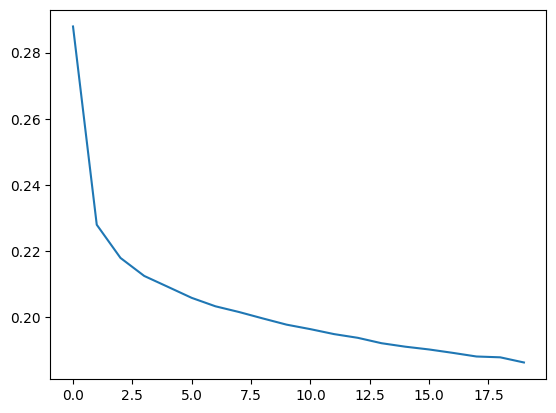

In [33]:
import matplotlib.pyplot as plt
plt.plot(losses)

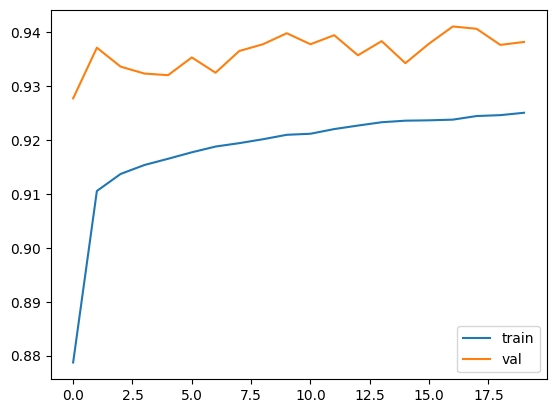

In [34]:
fig, ax = plt.subplots()

ax.plot(accuracies, label="train")
ax.plot(val_accuracies, label="val")
ax.legend()



## Visualizing the data
The prgram midi2vid can be used to visualize the midi files events.
if the right or left attribute is not set, the program will use a separate color. 
This can be used to visualize the wrong predictions of the model.

```
python3 src/main.py --source_path=/Users/oscar/pro/midi2hands/data/Bach-ItalienischesKonzert.mid --output_path=/Users/oscar/pro/midi2hands/data/Bach-ItalienischesKonzert.mp4 --events_path=/Users/oscar/pro/midi2hands/events/Bach-ItalienischesKonzert.json

python3 src/main.py --source_path=/Users/oscar/pro/midi2hands/data/Bach-ItalienischesKonzert.mid --output_path=/Users/oscar/pro/midi2hands/data/Bach-ItalienischesKonzert.mp4 --events_path=/Users/oscar/pro/midi2hands/events/Bach-ItalienischesKonzert.json
```

In [68]:
mp = MidiEventProcessor()

# get one file from the test paths
file_path = train_paths[2]
print(file_path)

# extract the note events
events = mp.extract_note_events(file_path)

# run inference on the events

def run_inference(events, model, window_size):
    y_pred = []
    for i in range(0, len(events), 1):
        if i==0:
            window = list(events[0])
        if i < window_size:
            window = events[0:i]
        elif i >= len(events) - window_size:
            window = events[i:]
        else:
            window = events[i:i + window_size]
        window = preprocess_window(window)
        window = torch.tensor(window).float().to(device).unsqueeze(0)
        output = model(window)
        output = torch.sigmoid(output).squeeze().cpu().detach().numpy()
        print(output)
        output = 0 if output < 0.5 else 1
        y_pred.append(output)
    print("outputs", len(y_pred))
    print("events", len(events))
    assert len(y_pred) == len(events)
    return y_pred

y_pred = run_inference(events, model, window_size=30)

# compare the outputs with the ground truth, 0 is left hand, 1 is right hand
y_true = [0 if event.hand == "left" else 1 for event in events]

print(f"Acuuracy for {file_path.name}: {accuracy(y_true, y_pred)}")

# update the events with the predictions
for i, event in enumerate(events):
    # set none on incorrect predictions
    if y_pred[i] != y_true[i]:
        event.hand = None

# now we should be able to visualize the events


data/Schubert_MomentMusical_3.mid
0.030652612
0.8285943
0.9081771
0.99372226
0.84387934
0.9125793
0.9758685
0.5124639
0.5690028
0.94976723
0.10669228
0.27241856
0.040472
0.9674028
0.004271829
0.0148235895
0.2645964
0.9359211
0.01397334
0.996899
0.0062515005
0.5927213
0.053773448
0.9482428
0.021591002
0.99721223
0.003508181
0.0020941992
0.78648025
0.99492586
0.82996845
0.99447614
0.0013948174
0.99787104
0.084843196
0.0009462247
0.99444085
0.9611321
0.8016825
0.007083488
0.0036077194
0.99761343
0.0017873462
0.1843179
0.9669958
0.9887012
0.99115306
0.0035899456
0.45749992
0.9982754
0.0022077542
0.043963384
0.9989415
0.00060433516
0.99741924
0.9704746
0.99962366
0.003031773
0.3765087
0.95126516
0.9963691
0.031137833
0.6217288
0.9988896
0.13163118
0.008203895
0.8273738
0.35166493
0.039990515
0.03704432
0.99630225
0.020480528
0.0020215712
0.003218018
0.5184853
0.010643669
0.22279254
0.92528796
0.075572066
0.005673886
0.9984975
0.05743375
0.011573506
0.0013894009
0.9947891
0.9166929
0.0018480